# INCEpTION - Importing annotations from Word

In this example, we will import annotations made as comments (or rather notes) in Word .docx files (see screenshot below for such a document) into INCEpTION. For this, we will

 

1.   Create the annotation configuration in INCEpTION and export its description as a TypeSystem.xml file
2.   Convert the notes and text of the .docx file to an INCEpTION compatible UIMA CAS XMI file
3.   Import the result UIMA CAS XMI file into INCEpTION



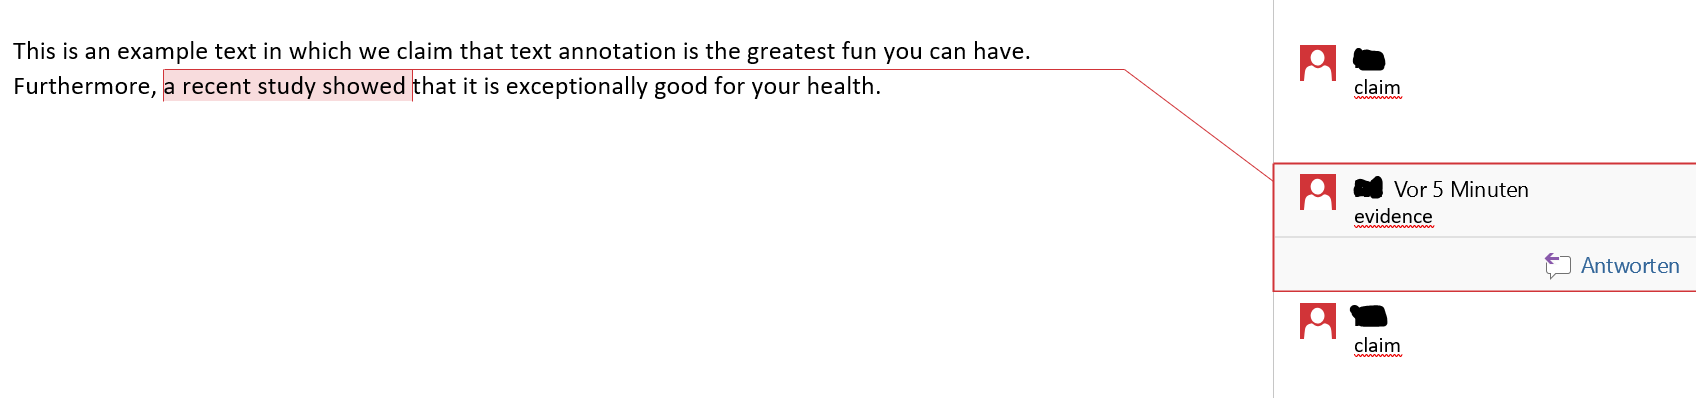

### 1. Create the annotation configuration

For this example, we want to create a text span annotation layer called **MyAnnotation** with one String feature **value**. We do this inside the INCEpTION tool on the *Settings* --> *Layers* page. If there are a lot of words in the comments, it might make sense to allow the *value* feature to cross multiple lines. This is done by checking the box *Multiple rows* in the *Feature Details* section of the feature configuration.

Then, we export the layer configurations as the UIMA TypeSystem.xml file. The information on the layer **MyAnnotation** also shows the internal name of this layer *webanno.custom.MyAnnotation* which we will later need to create new annotations of this type.



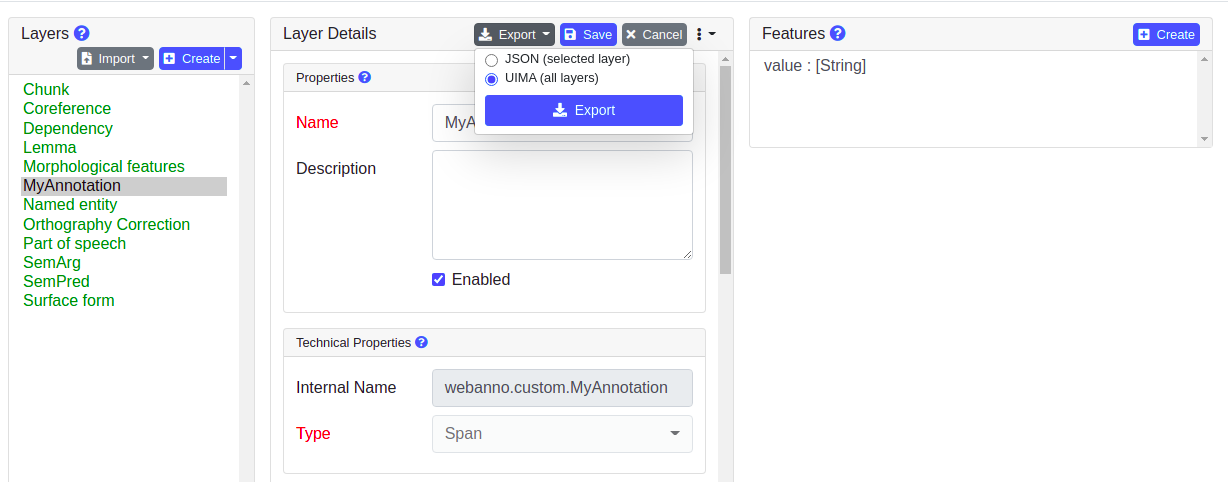

For the purpose of this example, we will create a condensed version of the TypeSystem.xml file by running the cell below.

In [7]:
%%writefile TypeSystem.xml
<typeSystemDescription xmlns="http://uima.apache.org/resourceSpecifier">
  <types>
    <typeDescription>
      <name>webanno.custom.MyAnnotation</name>
        <description/>
          <supertypeName>uima.tcas.Annotation</supertypeName>
          <features>
            <featureDescription>
              <name>value</name>
              <description/>
              <rangeTypeName>uima.cas.String</rangeTypeName>
            </featureDescription>
          </features>                
    </typeDescription>
  </types>    
</typeSystemDescription>

Writing TypeSystem.xml


## 2. Convert .docx to UIMA CAS XMI

We can run the following python script to convert the example file example.docx into example.xmi. If you want to run this example inside the colab notebook, create an example.docx file and upload it inside colab to *Files* (the folder icon on the left). 

Word documents are just zip files, so the script accesses the file as a .zip file. If you want to look at the contained files yourself, you can rename the file to example.zip on your local disk and extract it there. The document text is inside 'word/document.xml', the comments that represent our annotations are in 'word/comments.xml'. 

To create an annotation that can be written to the result UIMA CAS XMI file, we use the [dkpro-cassis library](https://github.com/dkpro/dkpro-cassis) which handles CAS data structures, the underlying data structures of INCEpTION. A CAS is initialized by the annotation description from the previously created TypeSystem.xml file. The CAS stores the document text and its annotations. An annotation contains its features and the beginning and end position of the annotation in the text.

With the script, we:

*   first, collect all comments (i.e. annotations) by traversing the comments.xml file in which they are referenced by their id. We store each comment's content with its id to later be able to refer back to it. The content will be used as the feature **value** of the annotation **MyAnnotation**.


*   Then, we extract the document text from the document.xml file by appending element texts. While traversing the file we encounter *comment range* elements that refer back to comments by their id. In this case, we can look up the associated comment by its previously stored id. Start and end positions of the text that is marked by the comment are given by the length of the appended document text when opening or closing the *comment range* element. From this information, we can create an annotation for the result CAS XMI file.

In [2]:
!pip install dkpro-cassis

In [8]:
import zipfile
from io import BytesIO
from typing import Dict, Set

import lxml.etree
from cassis import *

document = zipfile.ZipFile('example.docx')

namespaces = {"w": "http://schemas.openxmlformats.org/wordprocessingml/2006/main", "w14": "http://schemas.microsoft.com/office/word/2010/wordml"}
TAG_COMMENT_ID = "{" + namespaces["w"] + "}" + "id"

def get_texts(comments: Dict[int, str]):
    xml_content = document.read('word/document.xml')

    TAG_P = "{http://schemas.openxmlformats.org/wordprocessingml/2006/main}p"
    TAG_T = "{http://schemas.openxmlformats.org/wordprocessingml/2006/main}t"
    TAG_COMMENT_RANGE_START = "{http://schemas.openxmlformats.org/wordprocessingml/2006/main}commentRangeStart"
    TAG_COMMENT_RANGE_END = "{http://schemas.openxmlformats.org/wordprocessingml/2006/main}commentRangeEnd"

    comment_start = None

    text = ""

    with open("TypeSystem.xml", "rb") as f:
        ts = load_typesystem(f)

    cas = Cas(typesystem=ts)
    MyAnnotation = ts.get_type("webanno.custom.MyAnnotation")

    # The text in Word documents is inside w:t attributes
    # Comments
    comment_starts = {}
    for event, element in lxml.etree.iterparse(BytesIO(xml_content), events=("start", "end", )):
        tag = element.tag
        if event == "end" and tag == TAG_T:
            text += element.text
        if event == "end" and tag == TAG_P:
            text += "\n"
        elif event == "start" and tag == TAG_COMMENT_RANGE_START:
            comment_id = element.attrib[TAG_COMMENT_ID]
            comment_starts[comment_id] = len(text)
        elif event == "end" and tag == TAG_COMMENT_RANGE_END:
            comment_end = len(text)
            comment_id = element.attrib[TAG_COMMENT_ID]
            comment_start = comment_starts[comment_id]
            label = comments[comment_id]

            annotation = MyAnnotation(begin=comment_start, end=comment_end, value=label)
            cas.add_annotation(annotation)

    cas.sofa_string = text
    cas.to_xmi(r"example.xmi")


def get_comments() -> Dict[int, str]:
    xml_content = document.read('word/comments.xml')
    tree = lxml.etree.fromstring(xml_content)

    result = {}
    comments = tree.findall(".//w:comment", namespaces=namespaces)
    for comment in comments:
        comment_id = comment.attrib[TAG_COMMENT_ID]
        label = None
        comment_text_elements = comment.findall(".//w:t", namespaces=namespaces)
        if comment_text_elements is not None:
            label = ' '.join(elem.text for elem in comment_text_elements)
            # Remove non breaking space
            label = label.replace(u'\xa0', u' ')
        result[comment_id] = label

    return result

comments = get_comments()
get_texts(comments)


To sum up, the complex part of the script deals with parsing the xml files of the .docx file to extract document text, comment content and beginning and end of the marked text. Using *dkpro-cassis*, it is then quite easy to create annotations from this information and finally write the annotated text to a UIMA CAS XMI file.

## 3. Import UIMA CAS XMI files into INCEpTION

In INCEpTION, on the *Settings* --> *Documents* page, import the .xmi file(s) as UIMA CAS XMI. Opening the imported file on the annotation page, will then e.g. look like this :

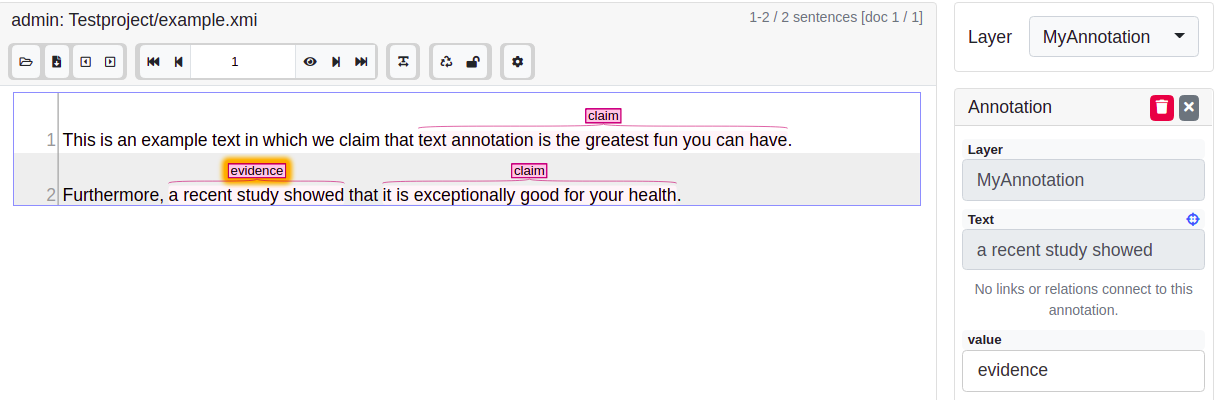